# 1. Data preprocessing

In [35]:
import pywt
from scipy.io import wavfile
import matplotlib.pyplot as plt
import numpy as np
import math

#### 1-1 Load source files

In [36]:
n = 100000
num_rec = 2
num_src = 3
BASE_DIR = "C:/Users/Daniel Choi/Desktop/comp-coursework/MATH4992/sources"

rate1, source1 = wavfile.read(f"{BASE_DIR}/bird.wav",n)
rate2, source2 = wavfile.read(f"{BASE_DIR}/male.wav",n)
rate3, source3 = wavfile.read(f"{BASE_DIR}/female.wav",n)

# store it to x
x = np.zeros([n,3])
x[:,0] = source1[:n]
x[:,1] = source2[:n]
x[:,2] = source3[:n]


In [37]:
print(rate1, rate2, rate3)

44100 16000 16000


#### 1-2 Normalize and display the sources

In [38]:
# Normalize x
x = x/np.tile(np.std(x,0),(n,1))

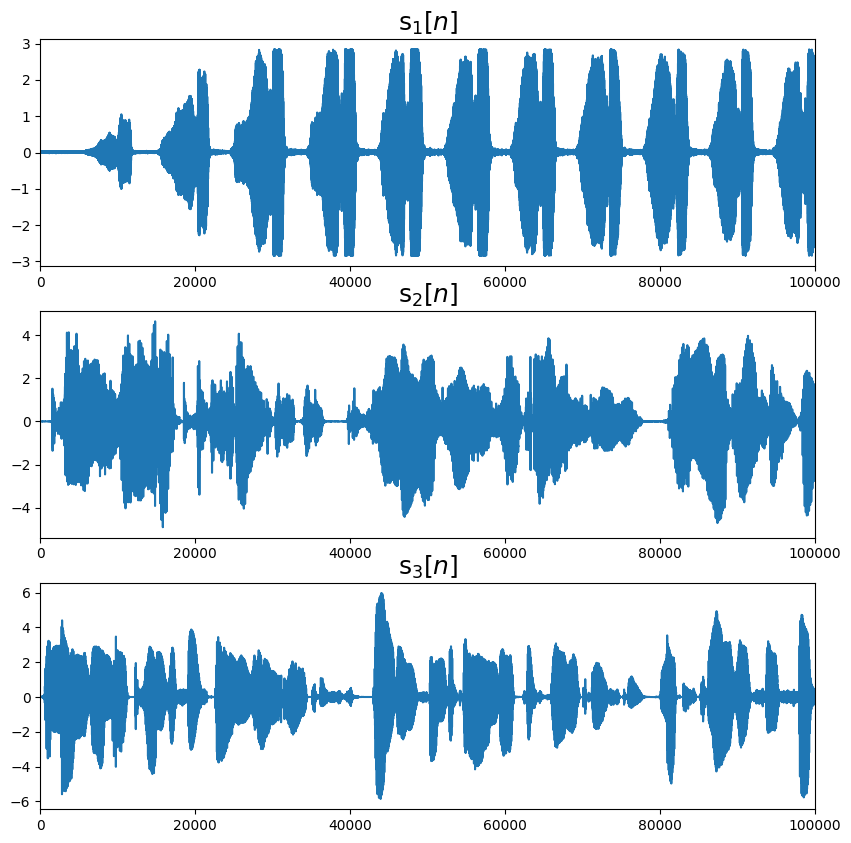

In [39]:
plt.figure(figsize = (10,10))

for i in range(num_src):
    plt.subplot(num_src, 1, i+1)
    plt.plot(x[:, i])
    plt.xlim(0,n)
    plt.title(f"s$_{i+1}[n]$", fontsize=18)

##### 1-3 Mix the sources

In [40]:
# Compute a 2x3 mixing matrix
theta = np.array([1/6, 0.4, 0.8])*np.pi
# theta=np.array([1/6, 0.4, 0.8])
M = np.vstack((np.cos(theta), np.sin(theta)))

# M is our ground truth mixing matrix
M

array([[ 0.8660254 ,  0.30901699, -0.80901699],
       [ 0.5       ,  0.95105652,  0.58778525]])

In [41]:
# M = np.array([[0.1,0.8,0.5],[1.2,0.7,-0.2]])

In [42]:
M.shape

(2, 3)

In [43]:
# Mix the sources!
y = np.dot(x, np.transpose(M))
y.shape

(100000, 2)

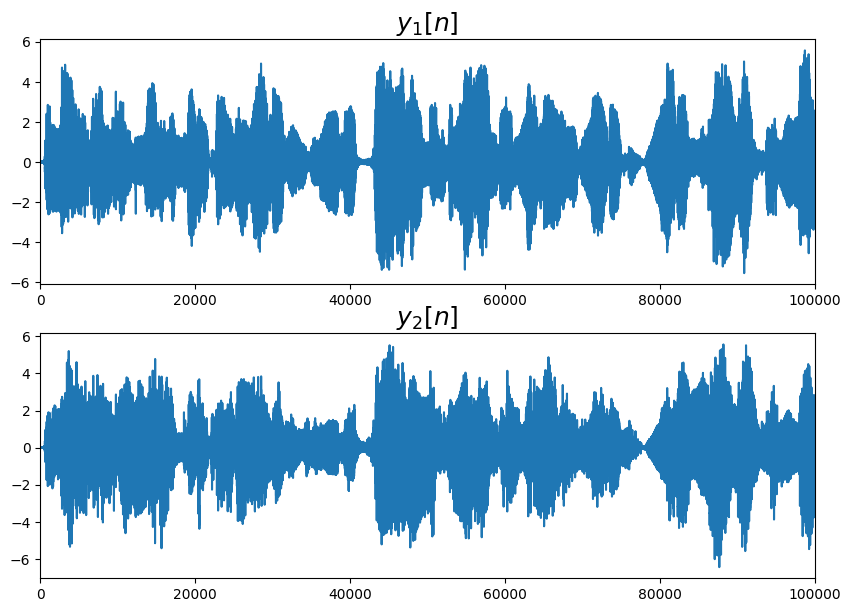

In [44]:
# Mixed sounds
plt.figure(figsize = (10,7))
    
for i in range(num_rec):
    plt.subplot(num_rec, 1, i+1)
    plt.plot(y[:, i])
    plt.xlim(0,n)
    plt.title("$y_%i[n]$" %(i+1), fontsize=18)

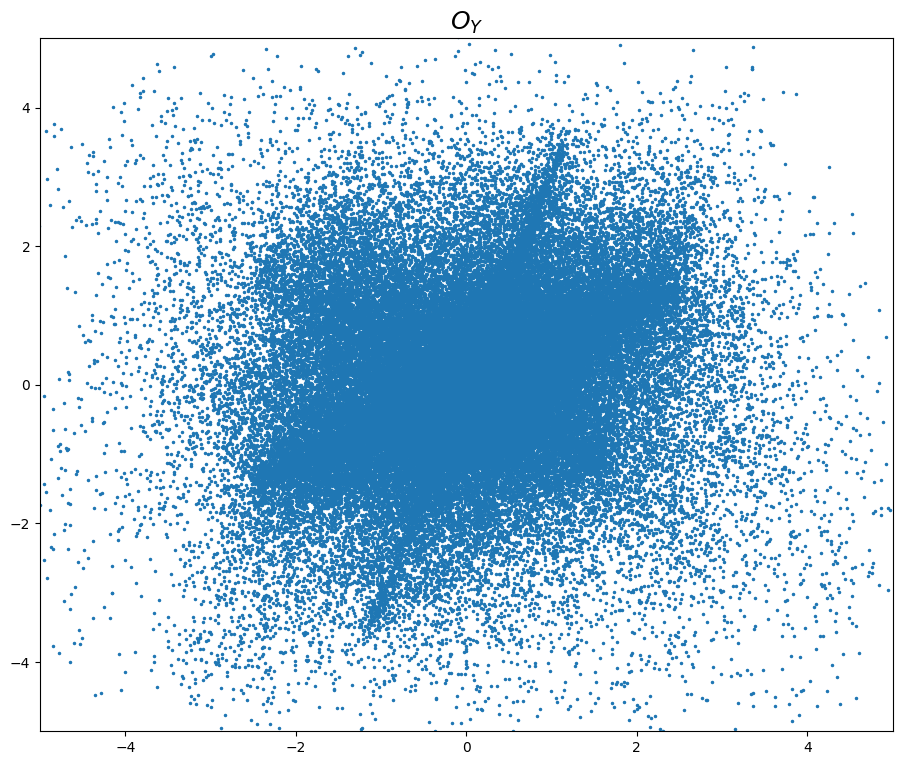

In [45]:
plt.figure(figsize = (11,9))
plt.title(f'$O_Y$', fontsize=18)

plt.plot(y[:, 0], y[:, 1], ".", ms = 3)

radius = 5
plt.xlim(-radius,radius)
plt.ylim(-radius,radius)
plt.show()

# 2. Multi-level Discrete Wavelet Transform

#### 2-1 Perform Discrete Wavelet Transform

In [46]:
# Usig pywt library, 
level = 5
wavelet = 'haar'

T = np.zeros([n,3])
coef_a = pywt.wavedec(y[:,0], wavelet=wavelet, level=level)
coef_b = pywt.wavedec(y[:,1], wavelet=wavelet, level=level)

In [47]:
len(y[:,0])

100000

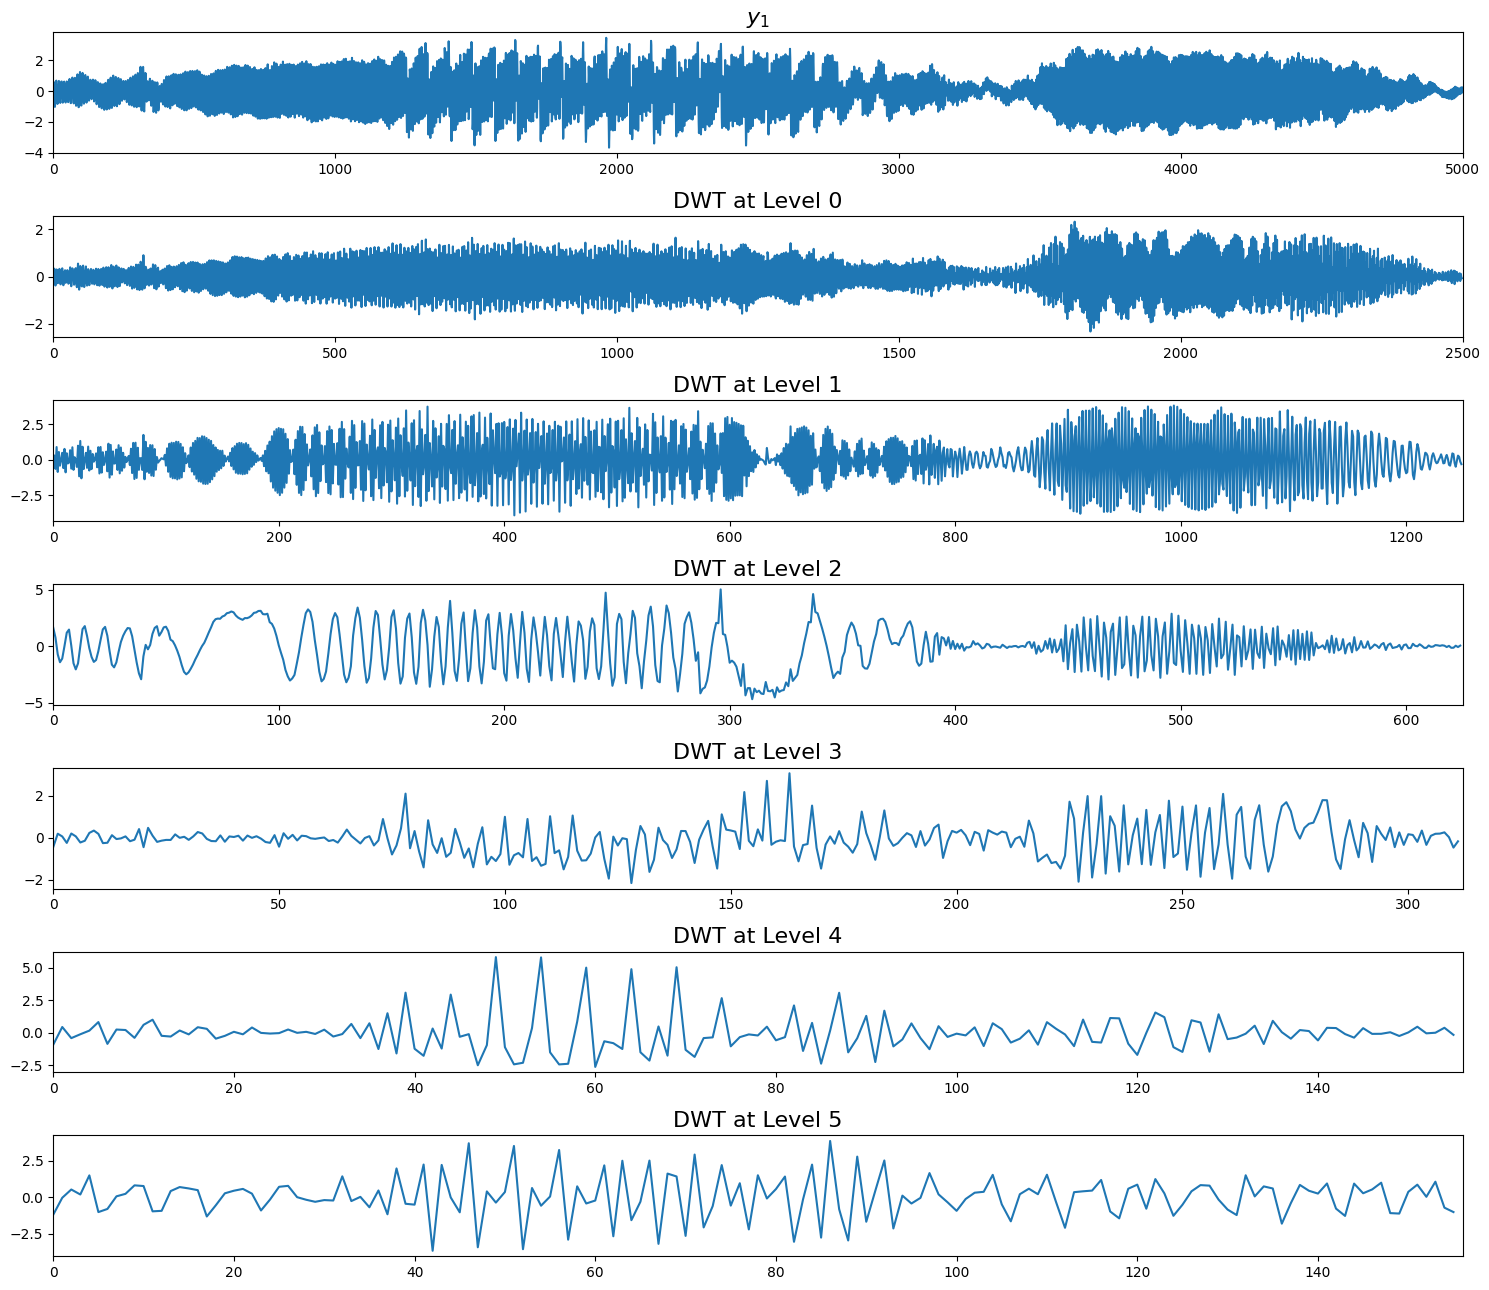

In [48]:
plt.figure(figsize = (15,13))

start = 0.7
end = 0.75
l = int(len(y[:,0])*start)
r = int(len(y[:,0])*end)
plt.subplot(len(coef_a)+1, 1, 1)
plt.plot(y[:,0][l:r])
plt.xlim(0, r-l)
plt.title(f"$y_1$", fontsize=16)

for i, c in enumerate(reversed(coef_a)):
    if i==len(coef_a):
        continue
    l = int(len(c)*start)
    r = int(len(c)*end)
    plt.subplot(len(coef_a)+1, 1, i+2)
    plt.plot(c[l:r])
    plt.xlim(0, r-l)
    plt.title("DWT at Level %s" % (str(i)), fontsize=16)


plt.tight_layout()

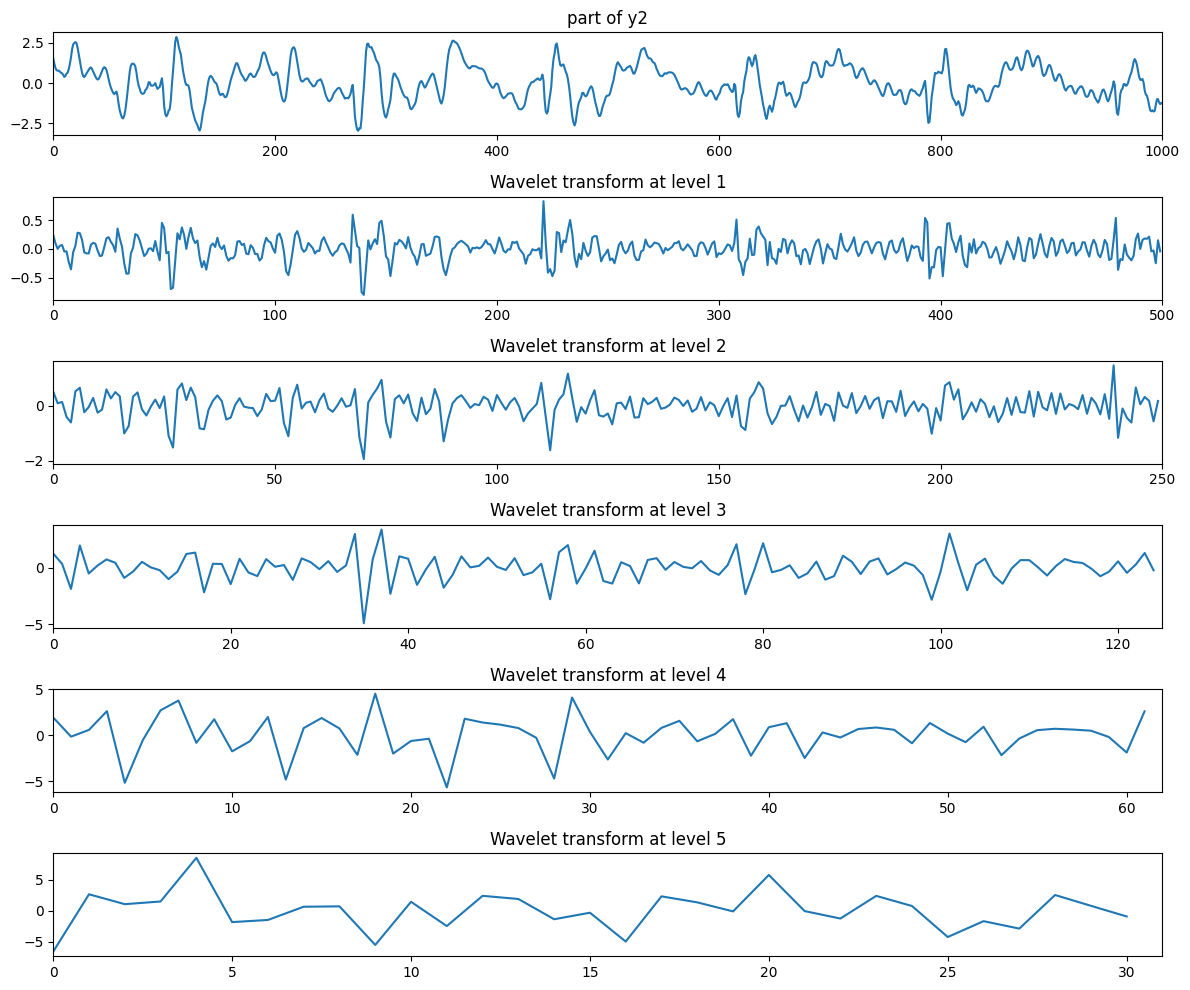

In [49]:
plt.figure(figsize = (12,10))
start = 0.605
end = 0.615

l = int(len(y[:,1])*start)
r = int(len(y[:,1])*end)
plt.subplot(len(coef_b), 1, 1)
plt.plot(y[:,1][l:r])
plt.xlim(0, r-l)
plt.title(f"part of y2")

for i, c in enumerate(reversed(coef_b)):
    if i==len(coef_b)-1:
        continue
    l = int(len(c)*start)
    r = int(len(c)*end)
    plt.subplot(len(coef_b), 1, i+2)
    plt.plot(c[l:r])
    plt.xlim(0, r-l)
    plt.title(f"Wavelet transform at level {i+1}")


plt.tight_layout()

#### 2-2 Plot the coefficients

In [50]:
# Helper function for creating coefficient map
def get_plot(x, y):
    if np.shape(x) != np.shape(y):
        raise ValueError('x and y should have same dimension')
    
    x_len = len(x)
    map_ = np.zeros([x_len, 2])
    map_[:,0] = x
    map_[:,1] = y    
    # npts = int(x_len*(1-drop))
    # sel = random.permutation(npts)
    # sel = sel[:npts]
    return map_

In [51]:
# Create map for each level
plots = []
for target_level in range(0, level+1):
    p = get_plot(coef_a[target_level], coef_b[target_level])
    plots.append(p)

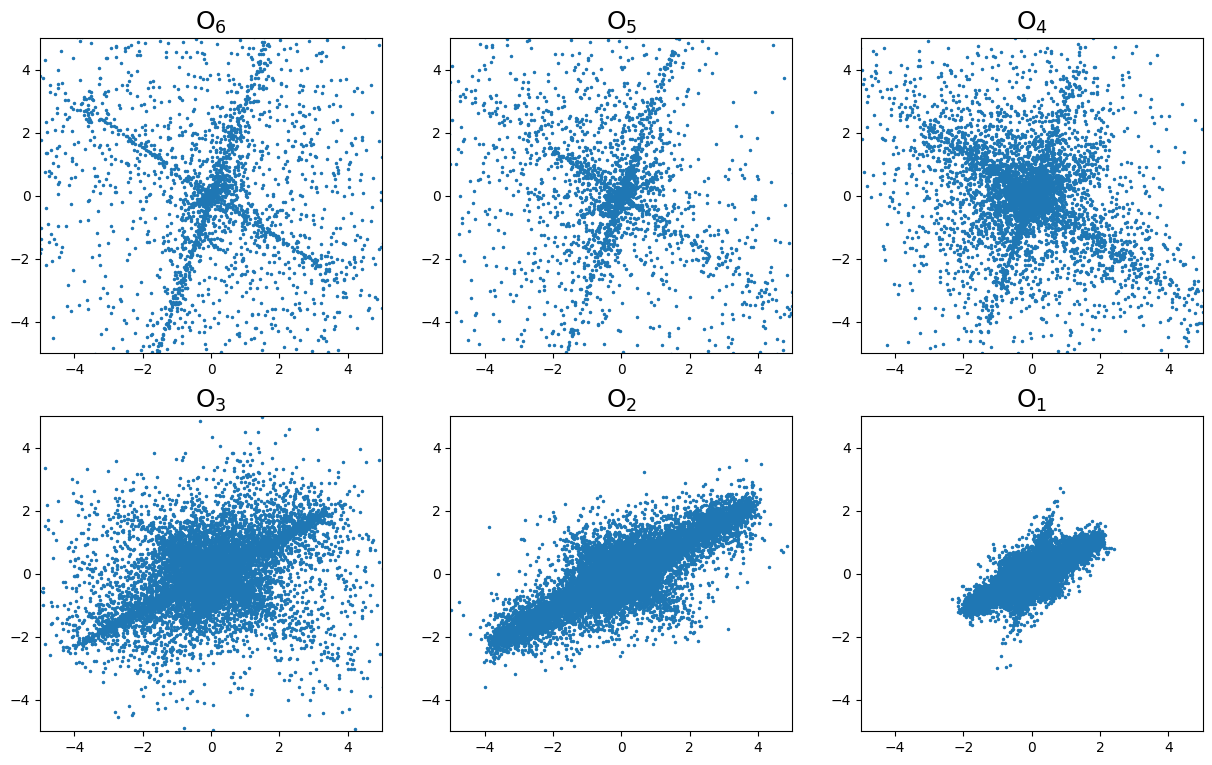

In [52]:
# Plot of each wavelet transform level
plt.figure(figsize = (15,9))
# plt.suptitle(f'Point Cloud Plots', fontsize=18)
for idx, plot in enumerate(plots):
    plt.subplot(int(level/3)+1, 3, idx+1)
    plt.plot(plot[:,0], plot[:,1], ".", ms = 3)
    radius = 5
    plt.xlim(-radius,radius)
    plt.ylim(-radius,radius)
    plt.title(f'O$_{level-idx+1}$', fontsize=18)
    # if idx == 0:
    #     plt.title(f'Apporximation Coefficient level {level}')
    # else:
    #     plt.title(f'Detailed Coefficient level {level-idx+1}')
plt.show()

Text(0.5, 1.0, 'O$_{cum}$')

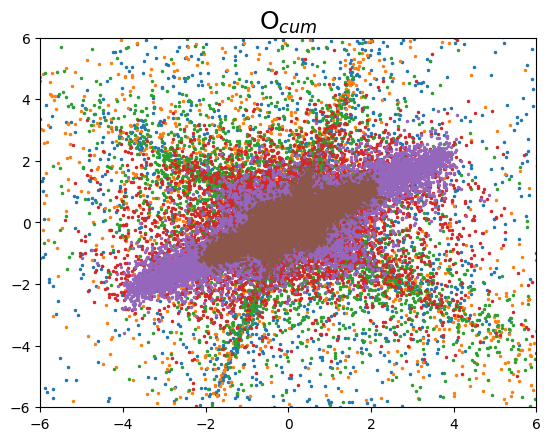

In [53]:
# Cumulative plot
for plot in plots:
    plt.plot(plot[:,0], plot[:,1], ".", ms = 3)
radius = 6
plt.xlim(-radius,radius)
plt.ylim(-radius,radius)
plt.title('O$_{cum}$', fontsize=18)

# 3. Analysis

#### 3-1 Show coefficient histogram using all data

In [54]:
# Helper function for calculating mixing matrix
def calculate_theta(data):
    nrow = np.shape(data)[0]
    Theta = np.zeros(nrow)
    for i in range(nrow):
        Theta[i] = math.atan2(data[i,1], data[i,0])%np.pi
    return Theta

In [55]:
# Get the mixing matrix
P = np.concatenate(plots)
Theta = calculate_theta(P)
Theta

array([0.57321053, 0.60808988, 0.61747326, ..., 0.38718719, 0.6046424 ,
       0.14853646])

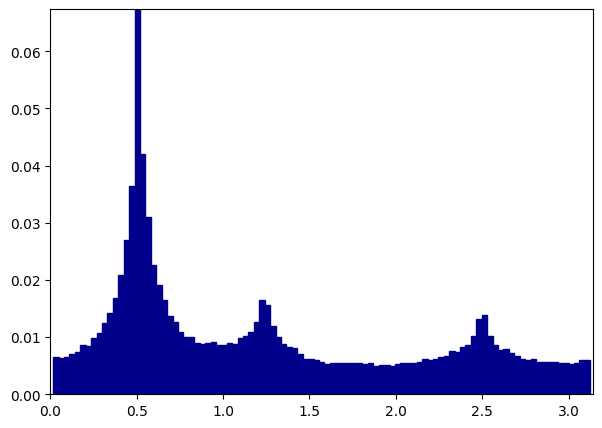

In [56]:
# Draw the histogram
nbins = 100
x = np.linspace(np.pi/100,np.pi,nbins)
hist = np.histogram(Theta,x)
h = hist[0]/np.sum(hist[0])
x = x[:-1]

plt.figure(figsize = (7,5))
plt.bar(x, h, width = np.pi/nbins, color = "darkblue", edgecolor = "darkblue")
plt.xlim(0,np.pi)
plt.ylim(0,np.max(h))
plt.show()

#### 3-2 Show coefficient histogram using top 10% data

In [69]:
# Do squared sum of P
d = np.sum(P**2, 1)

# only extract top 10% of items
threshold = .04
maxlen = round(threshold*len(d))+1

# extract results
I = np.argsort(d)[::-1]
I = I[np.arange(1,maxlen)]
P1 = P[I,:]  
    
#compute Theta with extracted data
Theta = calculate_theta(P1)
Theta

array([2.46312249, 2.38310707, 2.24558776, ..., 2.50691705, 2.645251  ,
       2.72559797])

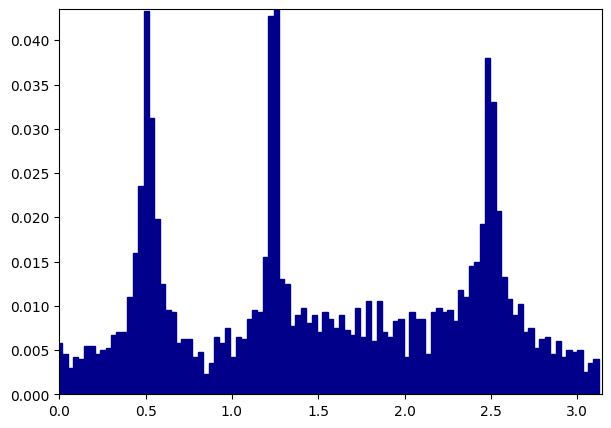

In [70]:
# Show histogram
nbins = 100
hist = np.histogram(Theta,nbins)
h = hist[0]/np.sum(hist[0])
t = hist[1][:-1]

plt.figure(figsize = (7,5))
plt.bar(t, h, width = np.pi/nbins, color = "darkblue", edgecolor = "darkblue")
plt.xlim(0,np.pi)
plt.ylim(0,np.max(h))
plt.show()

#### 3-3 Estimate the mixing matrix

In [59]:
# Helper function for calculating mixing matrix

def estimate_mixing_matrix(histogram, nbins)->np.ndarray:
    s1 = np.hstack((np.arange(2,nbins+1),np.array([nbins-1]))) - 1
    s2 = np.hstack((np.array([2]),(np.arange(1,nbins)))) - 1
    I = np.where((histogram[s1] < histogram ) & (histogram[s2] < histogram))

    u = np.argsort(histogram[I])[::-1]
    theta1 = t[I[0][u[:3]]]
    return np.vstack((np.cos(theta1), np.sin(theta1)))

In [60]:
M_hat = estimate_mixing_matrix(h, nbins)

print("--- M ---")
print(M)
print("--- M_hat ---")
print(M_hat)


--- M ---
[[ 0.8660254   0.30901699 -0.80901699]
 [ 0.5         0.95105652  0.58778525]]
--- M_hat ---
[[ 0.87564211  0.33793971 -0.79011048]
 [ 0.48296055  0.94116776  0.61296446]]


#### 3-4 Restore sources using the mixing matrix

In [61]:
from typing import List

# Multiply wavelet coefficients with the mixing matrix
C:List[np.ndarray] = []
for i, (a, b) in enumerate(zip(coef_a, coef_b)):
    coef = np.zeros([len(a), 2])
    coef[:,0] = a
    coef[:,1] = b
    ans:np.ndarray = np.dot(np.transpose(M_hat),np.transpose(coef))
    C.append(ans)
    if i == 0:
        print(f"Approximation Coefficient has shape: {ans.shape}")
    else:
        print(f"Detailed Coefficient {i} has shape: {ans.shape}")

Approximation Coefficient has shape: (3, 3125)
Detailed Coefficient 1 has shape: (3, 3125)
Detailed Coefficient 2 has shape: (3, 6250)
Detailed Coefficient 3 has shape: (3, 12500)
Detailed Coefficient 4 has shape: (3, 25000)
Detailed Coefficient 5 has shape: (3, 50000)


In [62]:
# Threasholding the coefficients
C_new = []
for coef in C:
    c = np.zeros(coef.shape)
    c[:] = coef
    argm = np.argmax(abs(coef), axis=0)
    
    for col, v in enumerate(argm):
        for row in range(3):
            mult = 1 if row == v else 0
            c[row][col] *= mult
            
    # c[abs(c) < 0.005] = 0
    
    C_new.append(c)

In [63]:
plt.figure(figsize = (10,10))

ind = 5
start=int(0.25*len(C_new[ind][i,:]))
end=int(0.5*len(C_new[ind][i,:]))
for i in range(3):
    plt.subplot(3, 1, i+1)
    plt.plot(C[ind][i,start:end])
    plt.xlim(0,end-start)
    plt.title("Dot product %i" %(i+1), fontsize=18)
    
plt.tight_layout()

IndexError: index 5 is out of bounds for axis 0 with size 3

<Figure size 1000x1000 with 0 Axes>

(3, 3125)

In [ ]:
# Now perform inverse discrete wavelet transform
x_hat = np.zeros([n,3])
for i in range(3):
    idwt_coef = []
    for c in C_new:
        idwt_coef.append(c[i])
    restored = pywt.waverec(idwt_coef, wavelet=wavelet)
    x_hat[:, i] = restored
    rate = 44100 if i == 0 else 16000 # Remember bird.wav file had samplerate of 44100
    wavfile.write(f'restored{i}_lvl_{level}.wav', rate, restored)

In [ ]:
idwt_coef[0].shape

(3125,)

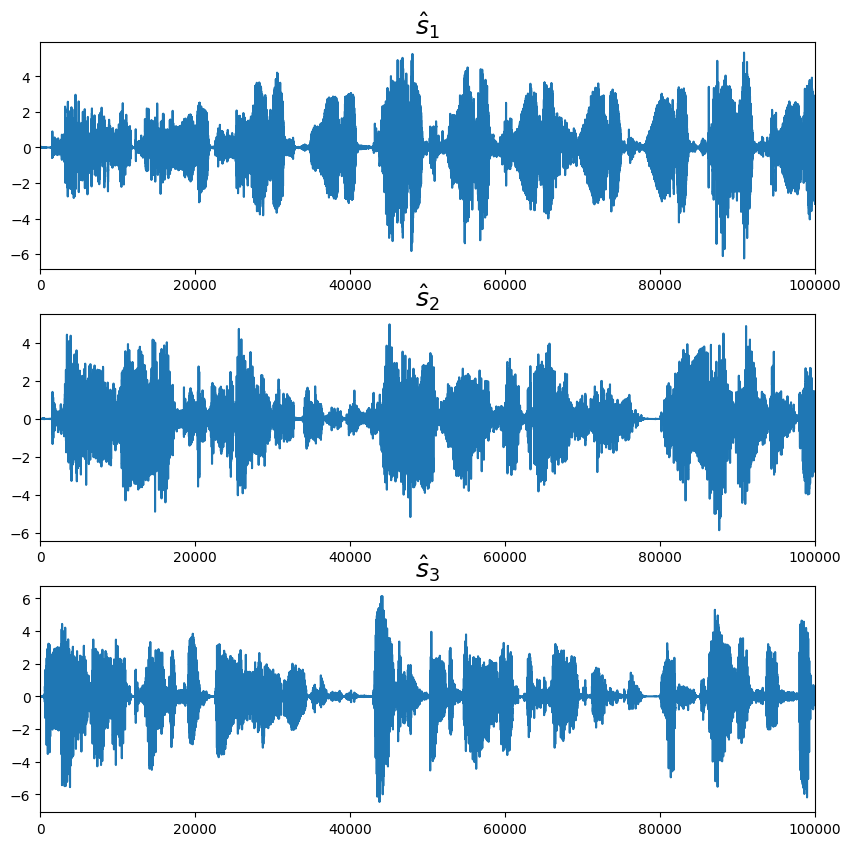

In [ ]:
plt.figure(figsize = (10,10))

for i in range(1):
    plt.subplot(1, 1, i+1)
    plt.plot(idwt_coef[:, i])
    plt.xlim(0,n)
    plt.title("$\hat s_%i$" %(i+1), fontsize=18)

In [ ]:
from scipy.io import wavfile
import noisereduce as nr
# load data
rate, data = wavfile.read("mywav.wav")
# perform noise reduction
reduced_noise = nr.reduce_noise(y=data, sr=rate)
wavfile.write("restored1_lvl_4.wav", rate, reduced_noise)

ModuleNotFoundError: No module named 'noisereduce'